In [1]:
import tensorflow as tf
import numpy as np
from numpy import save, asarray
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle
from IPython.display import Image
import os

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
import json
import sys
from batchup import data_source
from collections import Counter

from sklearn.cluster import KMeans, SpectralClustering

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

from sklearn import metrics 
from scipy.spatial.distance import cdist

from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import pandas as pd

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
tf.keras.backend.clear_session()

In [3]:
models_path = '/datasets/home/21/321/ee228sp20ta1/G51/models/'
val_path = '/datasets/home/21/321/ee228sp20ta1/G51/val_set.npy'
val_ids_path = '/datasets/home/21/321/ee228sp20ta1/G51/val_ids.txt'

In [4]:
f=open(val_ids_path, "r")
val_spec_ids = f.read()
val_spec_labels = val_spec_ids.split('\n')

In [5]:
X_valid = np.load(val_path)
X_valid = X_valid.reshape((2763*96,216))

unscaled_val_set = X_valid.reshape(2763,96,216,1)

print(X_valid.shape)

scaler = MinMaxScaler().fit(X_valid) 
scaled_valid = scaler.transform(X_valid)


s_valid_reshaped = scaled_valid.reshape(2763,96,216,1)
val_set = s_valid_reshaped

(265248, 216)


In [6]:
def ModelB():
    
    #### Encoder ####
    model = models.Sequential()
    model.add(keras.Input(shape=(96,216,1)))
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(14, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    #### Decoder ####
    model.add(layers.Conv2D(14, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(1,(3, 3), padding='same'))
    
    return model

In [7]:
AE_B = ModelB()

cwd = os.getcwd()
AE_B.load_weights(cwd+'/ExpTestModels228/ModelB1/modelB1')


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
ds = data_source.ArrayDataSource([val_set])

latent_vecs = []

get_hl = K.function([AE_B.layers[0].input], [AE_B.layers[4].output])

for batch in ds.batch_iterator(batch_size=64, shuffle=False):
    AE_h1 = get_hl([batch])[0]
    latent_vecs.append(AE_h1)
    
latent_vecs = asarray(latent_vecs)
latent_vecs = np.concatenate(latent_vecs)

In [11]:
latent_vectors = np.ndarray(shape=(2763,168,108))

for idx, spec in enumerate(val_set):
    latent_vec = latent_vecs[idx].reshape(168,108)
    latent_vectors[idx] = latent_vec

reshaped_latent_vectors = latent_vectors.reshape(2763,18144)
X = reshaped_latent_vectors

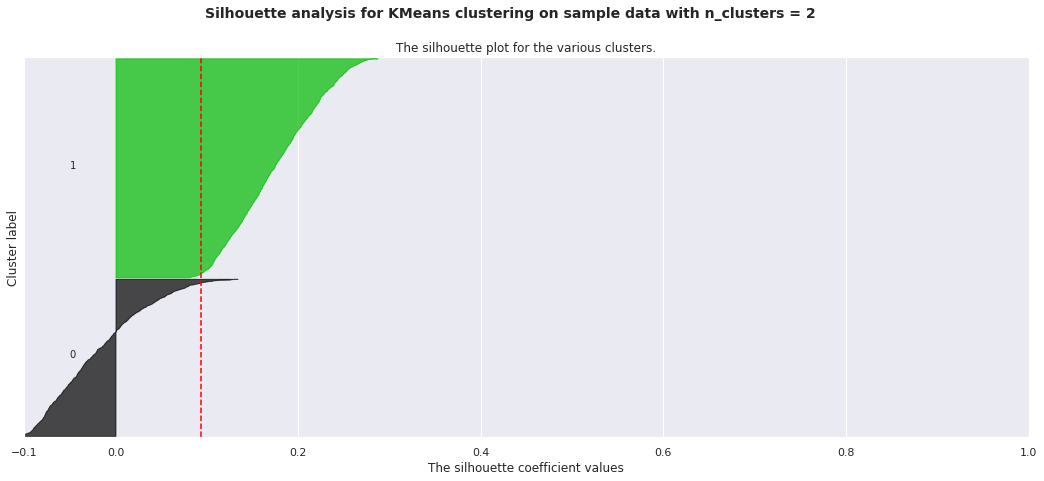

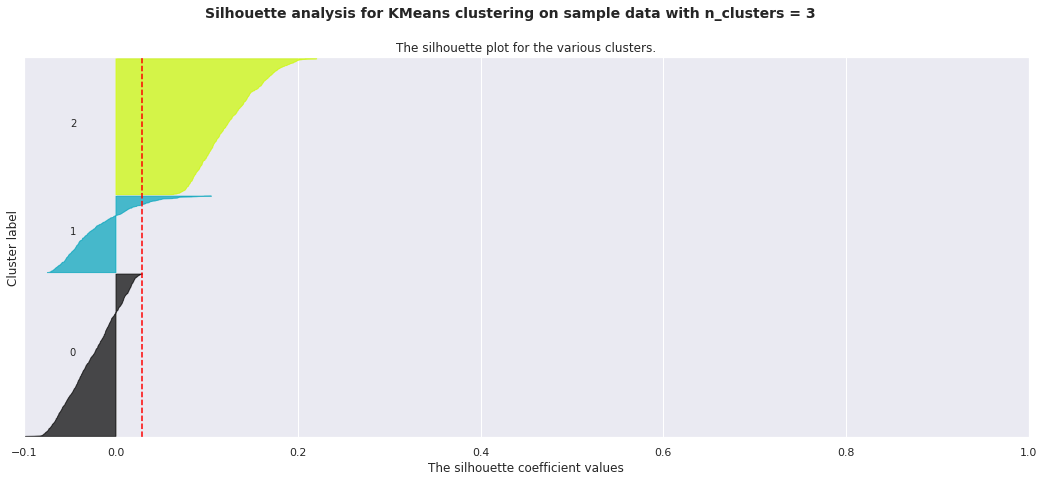

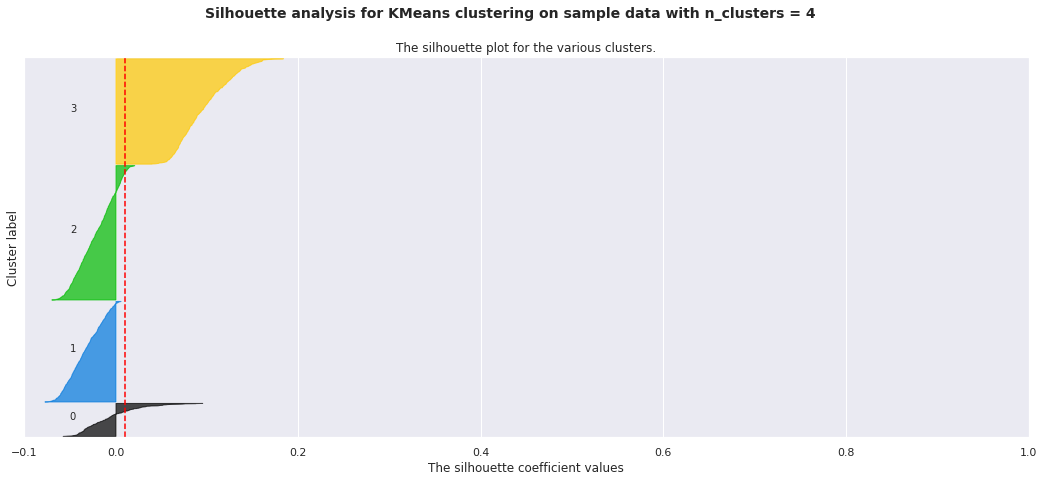

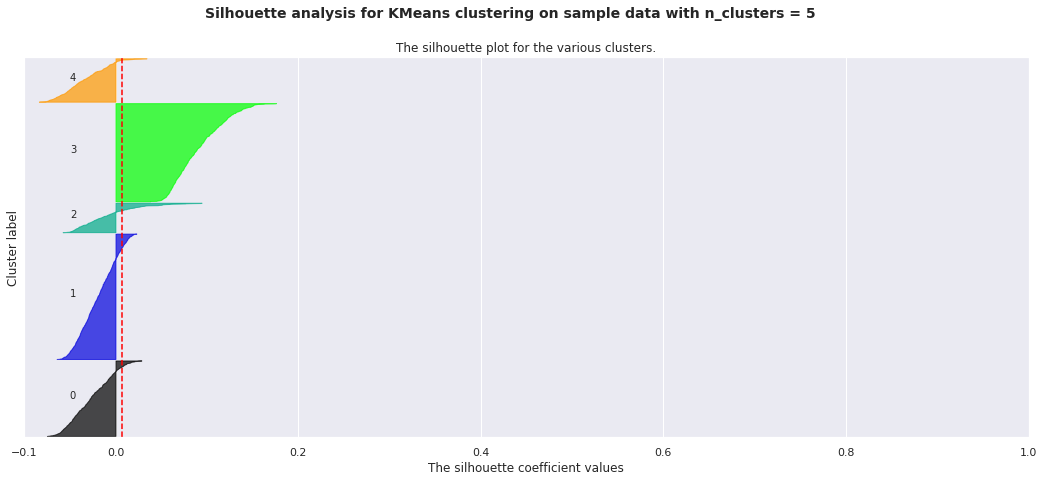

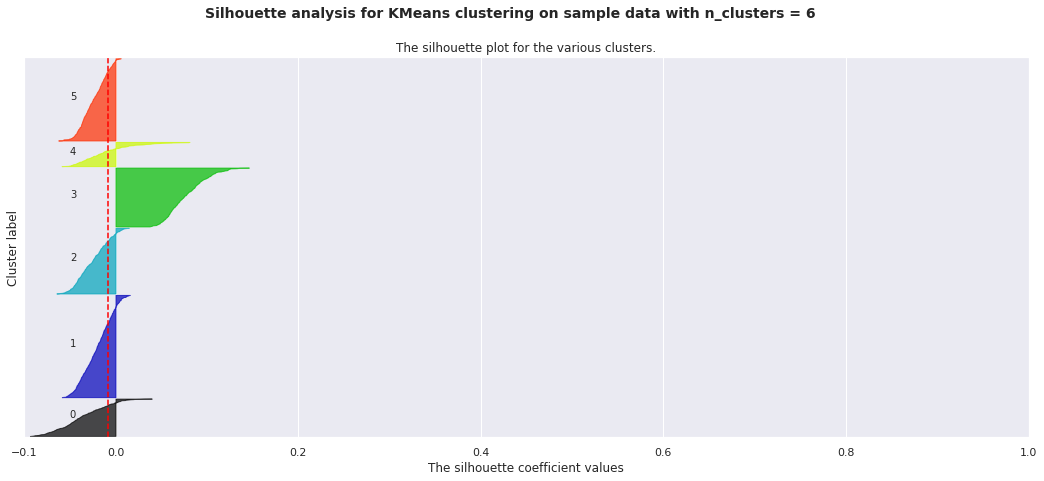

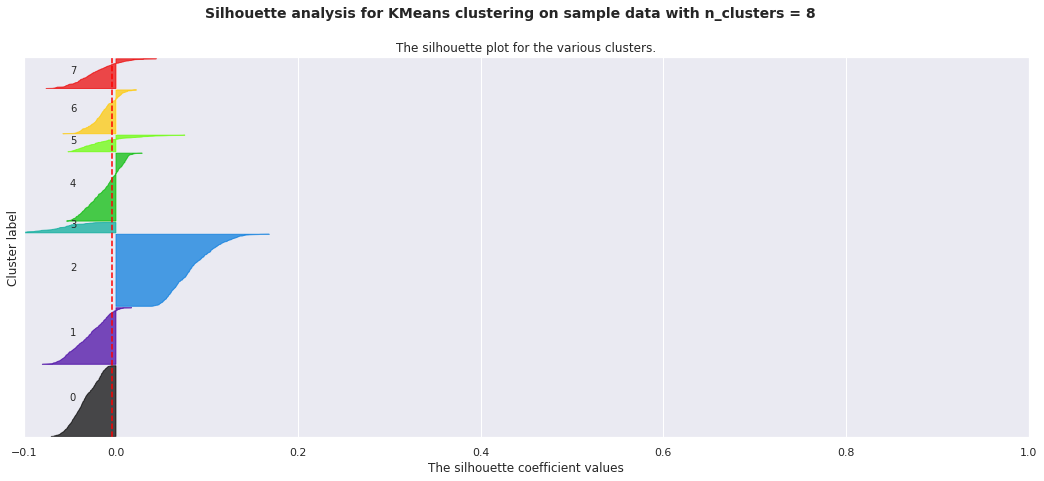

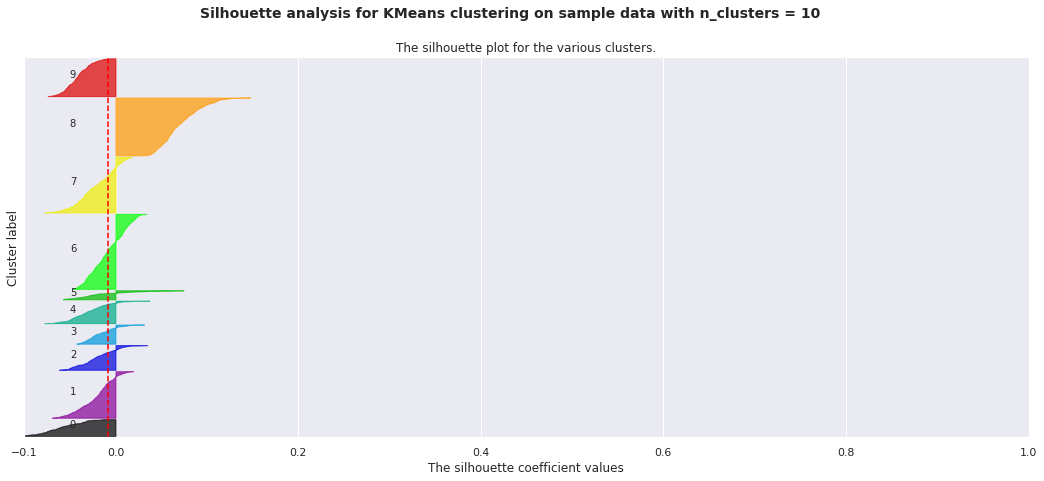

In [13]:
stdout_obj = sys.stdout             # store original stdout 

sys.stdout = open("{}_silhouette.txt".format('ModelB'), "w")

range_n_clusters = [2,3,4,5,6,8,10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
plt.show()

sys.stdout.close()
sys.stdout = stdout_obj 

In [14]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {}

range_n_clusters = [2,3,4,5,6,8,10]

for k in range_n_clusters:
    
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

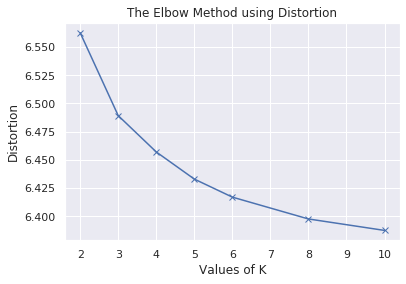

In [15]:
plt.plot(range_n_clusters, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.savefig('{}_elbow_distortion.png'.format('ModelB'), dpi=300, bbox_inches='tight')
plt.show() 

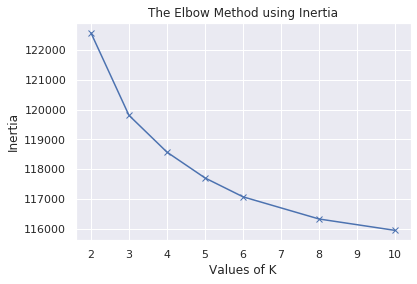

In [16]:
plt.plot(range_n_clusters, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.savefig('{}_elbow_inertia.png'.format('ModelB'), dpi=300, bbox_inches='tight')
plt.show() 

In [17]:
nclusters = 3
kmeans = KMeans(n_clusters=nclusters, init='k-means++', verbose =1).fit(reshaped_latent_vectors)

In [18]:
cluster_labels = kmeans.labels_

In [19]:
community_json = 'val_communities_3.json'

with open(community_json) as json_file:
    community_labels = json.load(json_file)

In [20]:
kmeans_labels = dict()
for idx, label in zip(val_spec_labels, cluster_labels):
    kmeans_labels[idx] = label

sorted_kmeans_labels = dict(sorted(kmeans_labels.items()))

sorted_community_labels = dict(sorted(community_labels.items()))

#This should be True
sorted_community_labels.keys() == sorted_kmeans_labels.keys()

True

In [21]:
community_labels = list(sorted_community_labels.values())
cluster_labels = list(sorted_kmeans_labels.values())

In [22]:
Counter(community_labels)

Counter({0: 2706, 1: 28, 3: 20, 2: 9})

In [23]:
Counter(cluster_labels)

Counter({2: 1193, 0: 1002, 1: 568})

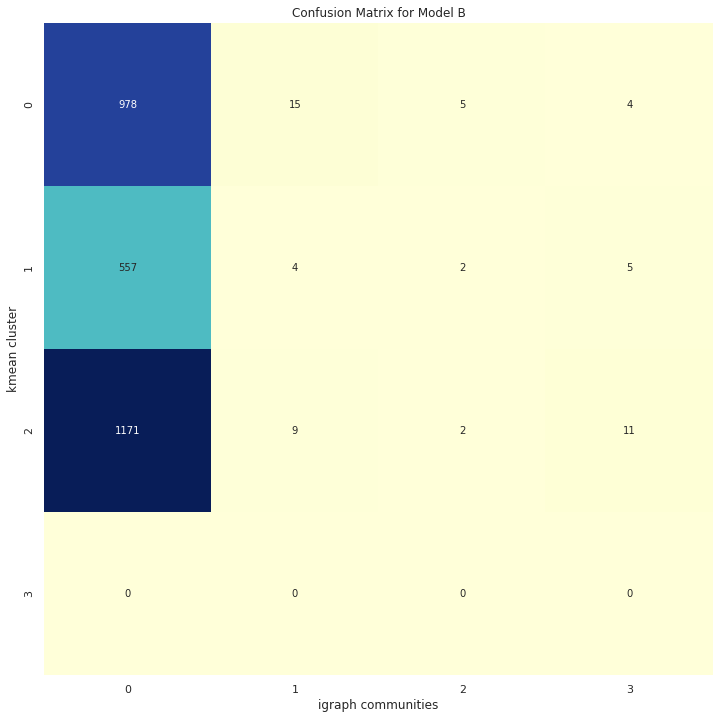

In [24]:
labels = kmeans.labels_
community = list(sorted_community_labels.values())
kmeanclusters = list(sorted_kmeans_labels.values())

mat = confusion_matrix(community, kmeanclusters)
fig, ax = plt.subplots(figsize=(12,12))  

sns.heatmap(mat.T, square=False, annot=True, fmt='d', cbar=False, cmap="YlGnBu", ax=ax)
plt.xlabel('igraph communities')
plt.ylabel('kmean cluster');
plt.title('Confusion Matrix for Model B')
plt.savefig('{}_confusion_matrix.png'.format('ModelB'), dpi=300, bbox_inches='tight')

In [25]:
X_embedded = TSNE(n_components=2).fit_transform(reshaped_latent_vectors)

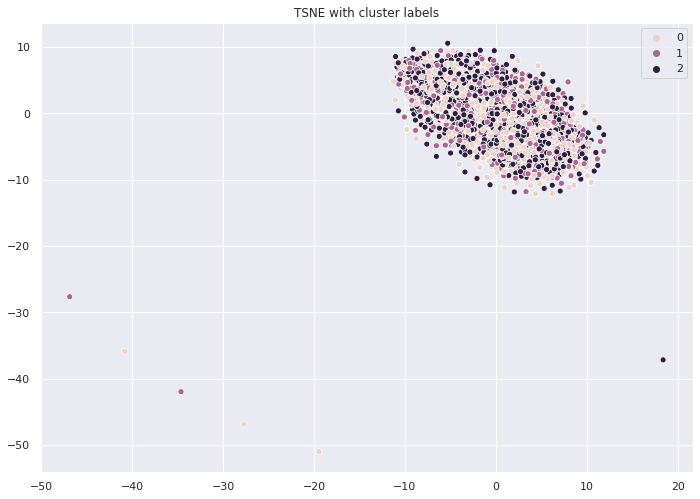

In [26]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=cluster_labels, legend='full')
plt.title('TSNE with cluster labels')
plt.savefig('{}_tnse_clusters.png'.format('ModelB'), dpi=300, bbox_inches='tight')

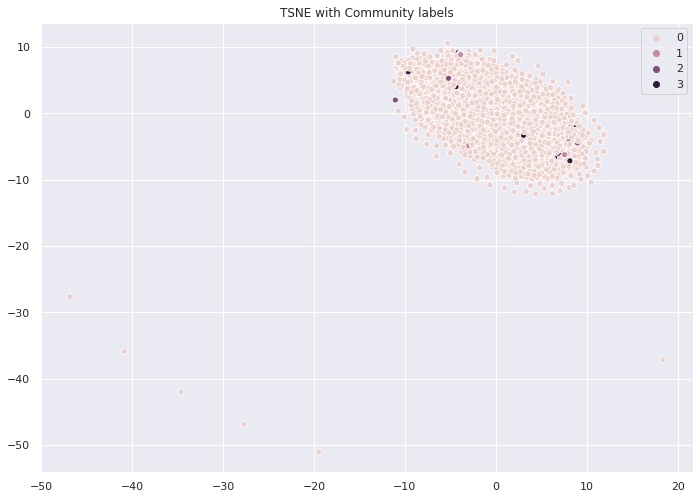

In [27]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=community_labels, legend='full')
plt.title('TSNE with Community labels')
plt.savefig('{}_tsne_community.png'.format('ModelB'), dpi=300, bbox_inches='tight')


In [28]:
df = pd.DataFrame()
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

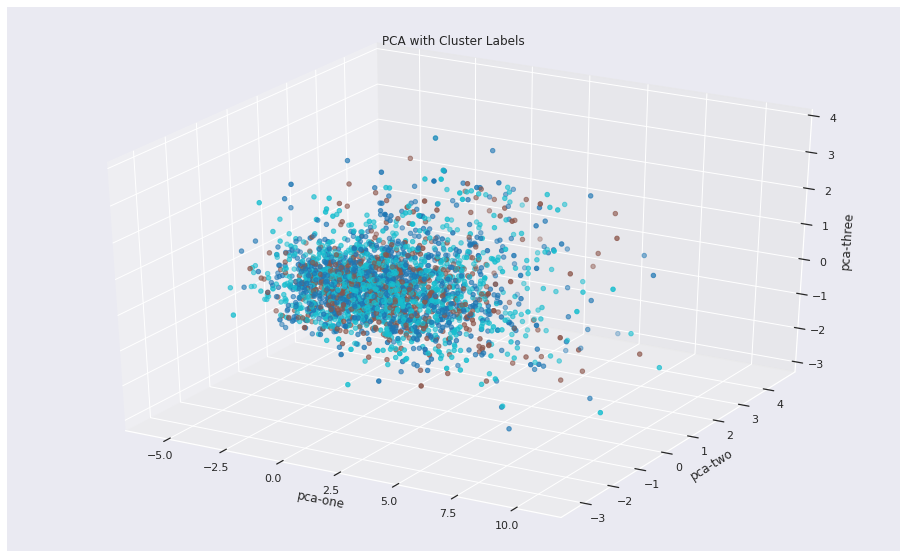

In [29]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[:,:]["pca-one"], 
    ys=df.loc[:,:]["pca-two"], 
    zs=df.loc[:,:]["pca-three"], 
    c=cluster_labels, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.title('PCA with Cluster Labels')
plt.savefig('{}_pca_clusters.png'.format("ModelB"), dpi=300, bbox_inches='tight')

plt.show()

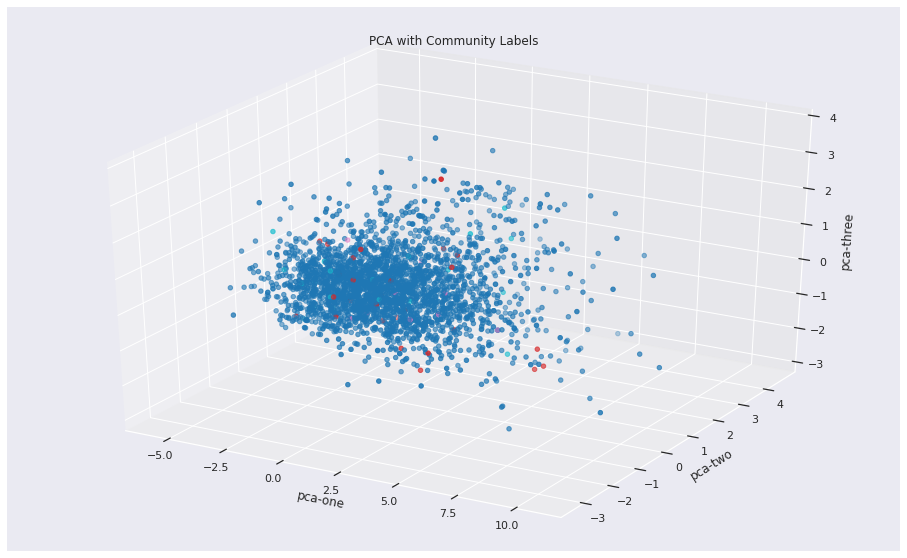

In [30]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[:,:]["pca-one"], 
    ys=df.loc[:,:]["pca-two"], 
    zs=df.loc[:,:]["pca-three"], 
    c=community_labels, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.title('PCA with Community Labels')
plt.savefig('{}_pca_community.png'.format("ModelB"), dpi=300, bbox_inches='tight')
plt.show()